<div style="text-align: right">INFO 6105 Data Sci Engineering Methods and Tools, Week 7 Homework</div>
<div style="text-align: right">Dino Konstantopoulos, 25 February 2023</div>

# Airlines, love them or leave them

<br />
<center>
    <img src="plane-bird.jpg" width=600 />
</center>

Let's try to model the customer support for various well-known airlines.

I will attempt to model one of the relevant distributions in the dataset, and you will try to improve my model.

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
%matplotlib inline 

from IPython.display import Image
import arviz as az
import pymc3 as pm 
import scipy 
import scipy.stats as stats 
import scipy.optimize as opt
import statsmodels.api as sm 

In [3]:
airlines = pd.read_csv(r'airlines.csv')

The dataset enumerates conversations between users and airlines, and records when the conversation took place and how long it took for the airline to respond to the customer inquiry.

We will model inquiry response time as a representative distribution of the quality of customer service.

In [4]:
airlines.sample(n = 20)

Unnamed: 0  author_id_x         created_at_x  \
51570      519979       302607  2017-10-19 00:26:29   
83239      840362       798019  2017-11-28 04:28:30   
80591      819159       778457  2017-11-22 01:39:13   
57622      595506       613983  2017-10-10 12:01:34   
39200      387837       447753  2017-10-28 18:53:37   
83082      839314       429834  2017-11-28 02:36:53   
25628      255969       343682  2017-10-14 00:12:27   
76443      781508       754258  2017-10-31 15:43:51   
16615      175965       275855  2017-11-22 21:58:18   
52194      526136       558865  2017-10-20 00:18:06   
32753      324540       398311  2017-10-15 19:13:06   
5783        68428       178825  2017-10-05 22:10:25   
62959      649759       655389  2017-11-10 18:55:23   
40638      402857       459487  2017-11-26 01:45:58   
73255      751422       732094  2017-11-16 22:56:45   
69620      717671       578178  2017-11-15 12:10:54   
7976        87764       195933  2017-10-07 20:32:46   
10659      109947       215344  2017-09-16 10:21:27   
44227      434770       484920  2017-11-04 14:02:22   
61612      637583       645988  2017-11-10 04:28:56   

                                                  text_x      author_id_y  \
51570  @virginamerica so disappointed. taking new air...    VirginAmerica   
83239  Hey @SouthwestAir cannot get online check-in t...     SouthwestAir   
80591  .@SouthwestAir just checking back in! no respo...     SouthwestAir   
57622         @Delta comfort+ 🤘🏼 https://t.co/nElrpPi9Vc            Delta   
39200  @AmericanAir , the lady at B2 was so nice and ...      AmericanAir   
83082  @SouthwestAir : pleaaaase help. My in-laws can...     SouthwestAir   
25628  @AlaskaAir um WOW! I know you guarantee 20min ...        AlaskaAir   
76443  @SouthwestAir is a photocopy of my infant's bi...     SouthwestAir   
16615  @AlaskaAir Delayed in traffic and will be arri...        AlaskaAir   
52194                   Never flying @AmericanAir again.      AmericanAir   
32753  Flight delay blues @AmericanAir https://t.co/b...      AmericanAir   
5783   Thank you @AmericanAir for having such wonderf...      AmericanAir   
62959  @Delta on Dl142 (ANC-SEA). Sitting on tarmac w...            Delta   
40638  Hey @Delta I’ve been on hold now for 20 mins c...            Delta   
73255  Super job on these 757 retrofits, @AmericanAir...      AmericanAir   
69620  @delta About to drop more for my toddler and I...            Delta   
7976   Kudos to @Delta for a thoughtful policy &amp; ...     SouthwestAir   
10659  @British_Airways We travel with 3 young childr...  British_Airways   
44227  In #Amsterdam, a beautiful city, but should be...            Delta   
61612  I will never fly @AmericanAir ever again. I wa...      AmericanAir   

              created_at_y                                             text_y  \
51570  2017-10-19 00:47:40  @302607 I'm sorry about that, Alana.  Your saf...   
83239  2017-11-28 04:37:01  @798019 Hi, Karen. Sorry to hear you're having...   
80591  2017-11-22 02:06:04  @778457 Hi Ella. We responded to your DM earli...   
57622  2017-10-10 12:02:55  @613983 Oh my! Thank you for bringing this to ...   
39200  2017-10-28 19:21:10  @447753 Music to our ears! We'd like to pass t...   
83082  2017-11-28 02:42:27  @429834 Hi, Lindsey. Go ahead and DM us their ...   
25628  2017-10-14 00:14:09                          @343682 SAWEETNESS! -Tara   
76443  2017-10-31 15:48:22  @754258 Hi Matthew, that should be fine, as lo...   
16615  2017-11-22 22:04:41  @275855 Hi Mark!  Yes, I see that the flight i...   
52194  2017-10-20 00:34:42  @558865 We hope you'll reconsider and give us ...   
32753  2017-10-15 19:44:39  @398311 We're sorry for the wait. We can keep ...   
5783   2017-10-05 22:56:48  @178825 We're happy to hear our wonderful #AAT...   
62959  2017-11-10 19:17:49  @655389 I'm sorry it's taking more time than u...   
40638  2017-11-26 01:48:42  @459487 Really sorry to hear that and for the ...   
73255  2017-11-16 

# 1. Question 1

Let's plot the historgram of response time:

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


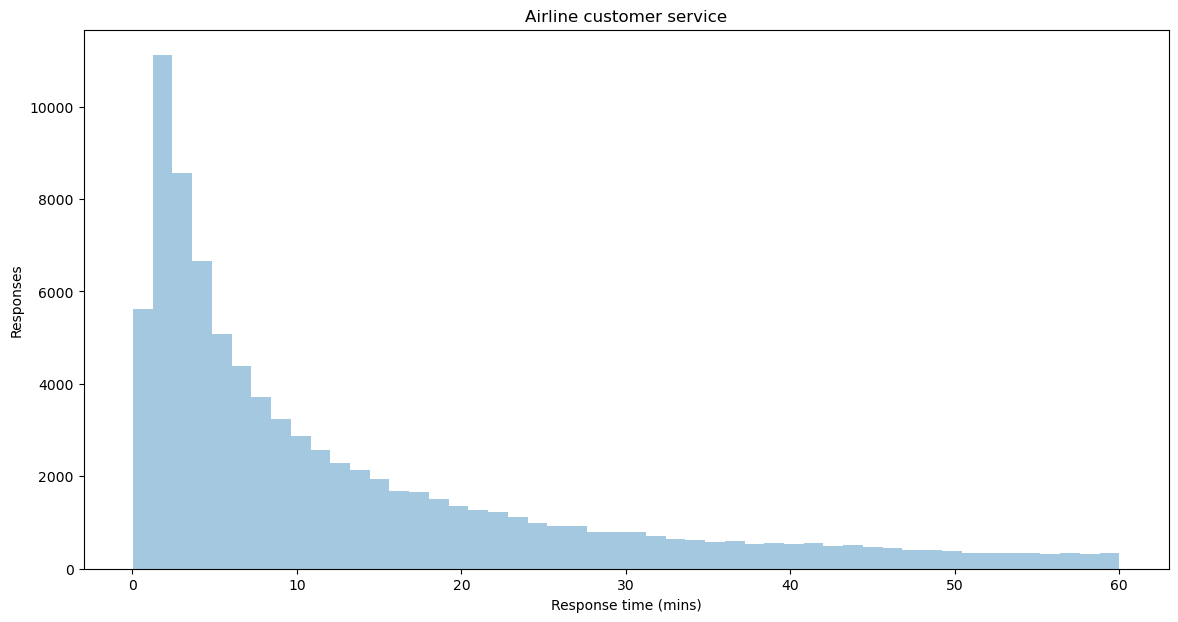

In [5]:
plt.figure(figsize = (14, 7))
sns.distplot(airlines['res_time'], kde = False)
plt.title('Airline customer service')
plt.xlabel('Response time (mins)')
plt.ylabel('Responses');

# Modeling with a Student-t data likelihood
A good option when dealing with outliers is to replace the Gaussian likelihood with a Student t-distribution. 

The Student-t has three parameters: the mean $\mu$, the scale $\sigma$ (analogous to the standard deviation), and the degrees of freedom $\nu$.

For a value of $ν = 1$, we get a distribution with heavy tails, with more outliers than a Gaussian.

We model the response time with a Student-t:

In [7]:
with pm.Model() as model1:
    mu = pm.Uniform('mu', lower = 0, upper = 60) 
    sd = pm.HalfNormal('sd', sd = 10)
    e = pm.Exponential('e', 1/1) 
    t = pm.StudentT('t', mu = mu, sd = sd, nu = e, observed = airlines['res_time'])

In [8]:
with model1:
    trace = pm.sample(2000, tune=2000)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e, sd, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 86 seconds.
The number of effective samples is smaller than 25% for some parameters.


Let's plot our model parameter posteriors:

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


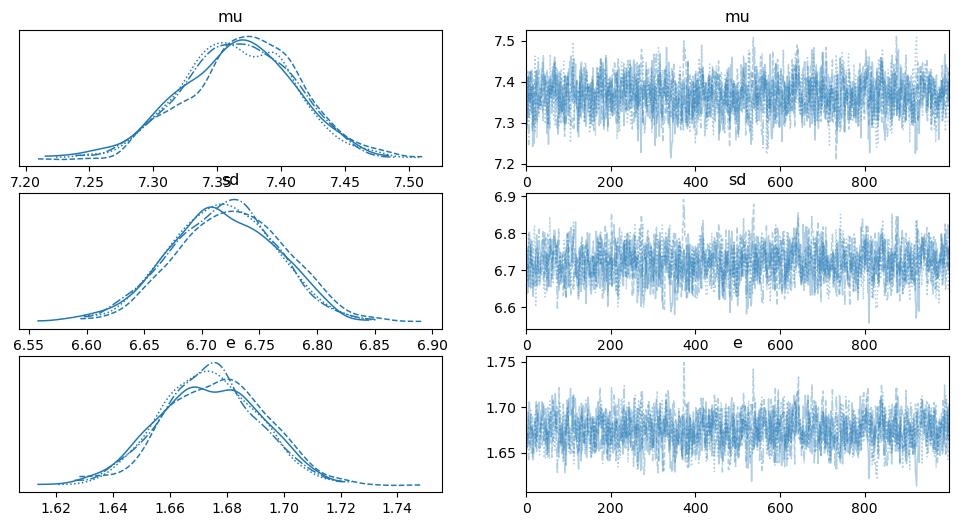

In [9]:
az.plot_trace(trace[:1000], var_names = ['mu', 'sd', 'e']);

To infer how close the posteriors are to the actual observation, we are going to sample from the posterior predictive (to create "fake" data), and then we are going to compare the hsitogram of the fake data to the empirical histogram.

In [10]:
ppc = pm.sample_posterior_predictive(trace, samples = 1000, model = model1)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [11]:
ppc

{'t': array([[-2.2843349 , 14.21814066,  8.57857634, ..., 10.4274984 ,
          3.8538222 ,  3.52263852],
        [-3.46908952, 17.148218  ,  1.98138923, ..., 13.34955006,
         -4.47524142, 11.97688211],
        [16.74594412, 17.03182268,  8.43434374, ..., 10.08832136,
         18.51214761,  8.85991161],
        ...,
        [30.8234174 , -5.04455267,  7.17077945, ..., 16.2209937 ,
          9.14552653,  4.67809552],
        [11.4469508 , -3.09064261, -3.49557865, ...,  4.94262576,
         10.16202022, 10.15596827],
        [52.62310784, 13.80899004, 11.28806386, ...,  2.35570324,
          6.97057627, 14.28977696]])}

Let's plot the histogram of the empirical response time and its mean:

[Text(0.5, 1.0, 'Empirical histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

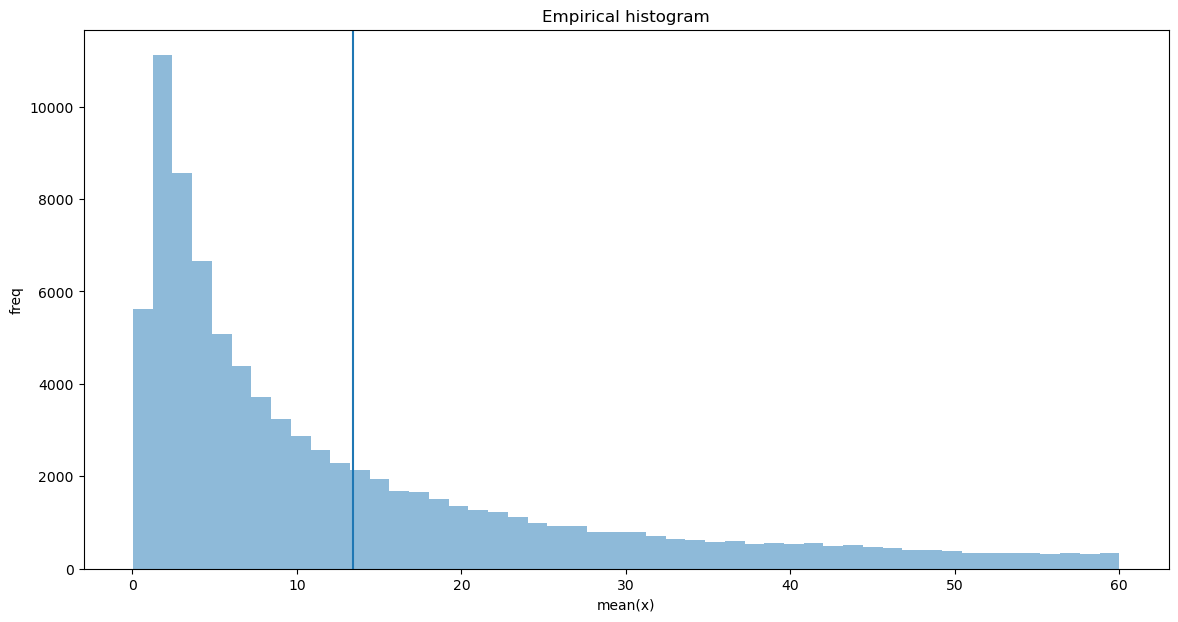

In [12]:
_, ax = plt.subplots(figsize = (14, 7))
plt.hist(airlines['res_time'], bins = 50, alpha = 0.5)
ax.axvline(airlines['res_time'].mean())
ax.set(title = 'Empirical histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

Let's plot the histogram of the model-simulated response time and the empirical mean:

[Text(0.5, 1.0, 'Simulated histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

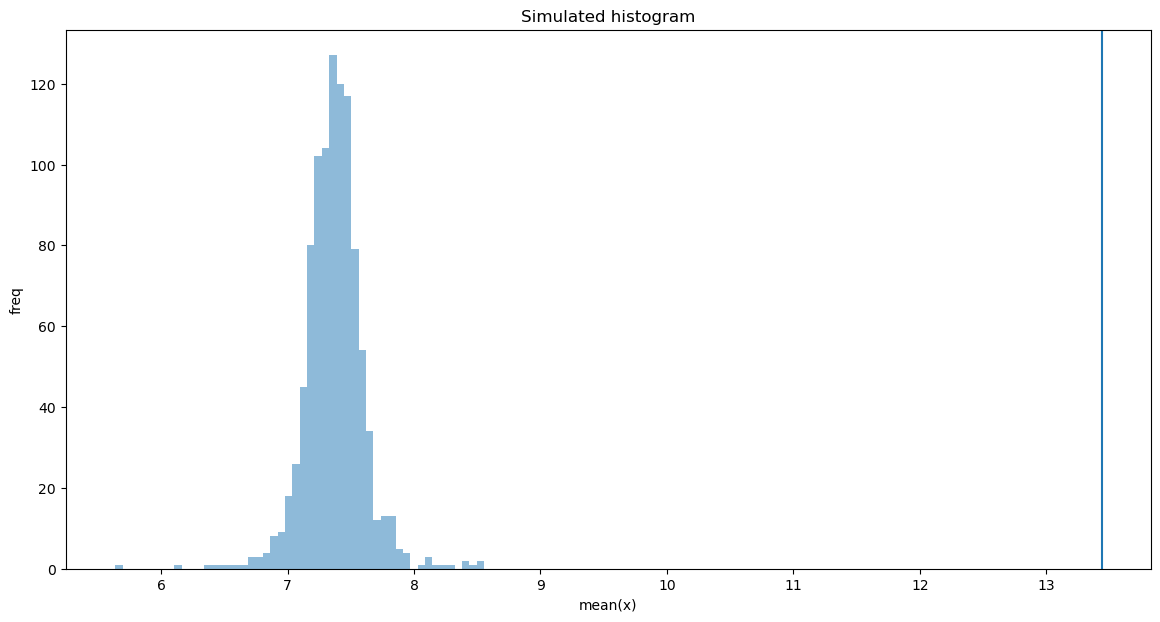

In [13]:
_, ax = plt.subplots(figsize = (14, 7))

ax.hist([n.mean() for n in ppc['t']], bins = 50, alpha = 0.5)
ax.axvline(airlines['res_time'].mean())
ax.set(title = 'Simulated histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

They don't match! In fact, the model seems to tell us that the mean of the distribution should be between 7.2 and 7.4.

In [14]:
with model1:
    display(az.summary(trace, round_to=2))

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
mu  7.37  0.04    7.28     7.45        0.0      0.0   2152.67   3588.39    1.0
sd  6.72  0.05    6.64     6.81        0.0      0.0   1925.05   3229.48    1.0
e   1.67  0.02    1.64     1.71        0.0      0.0   1943.45   3139.81    1.0

But taht's not even close! The empirical mean is: 

In [15]:
airlines['res_time'].mean()

13.436461105326302

# Homework question 1
Can you fix what professor did wrong in building the model?

In [28]:
res = airlines['res_time']
with pm.Model() as model3:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    nmd = pm.Normal('nmd', mu = mu, sd = sd, observed = res[(res >= 0) & (res < 10)])
    alpha = pm.HalfNormal('alpha', sigma=10)
    nu = pm.HalfNormal('nu', sigma=10)
    nb = pm.NegativeBinomial('nb', mu = alpha, alpha = nu, observed=res[(res >= 10)]) 
    

In [29]:
with model3:
    trace3 = pm.sample(1000, tune = 1000)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, alpha, sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


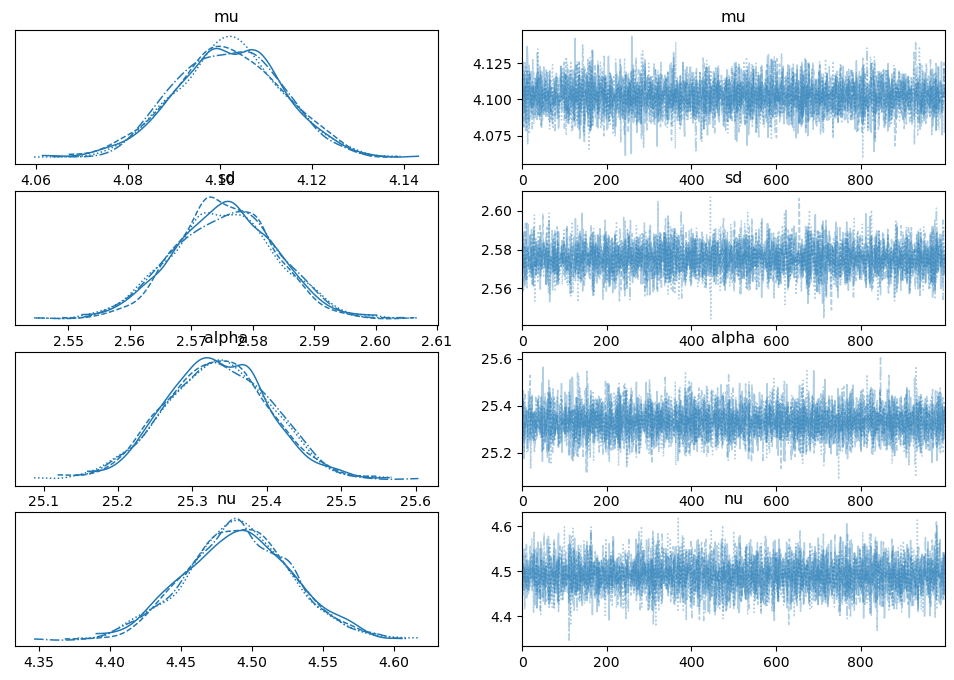

In [30]:
az.plot_trace(trace3[:1000], var_names = ['mu', 'sd', 'alpha','nu']);

In [31]:
ppc3 = pm.sample_posterior_predictive(trace3, samples = 1, model=model3)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


### Plotting both observations normal from 0 to 10 and negative binomial from 10 and above

In [32]:
ppc3

{'nmd': array([[7.14852109, 3.33488228, 5.59298455, ..., 2.91742198, 3.29541597,
         4.4994594 ]]),
 'nb': array([[56, 40, 23, ..., 11, 25, 25]])}

### Total observations

In [33]:
total = np.concatenate(list(ppc3.values()), axis = 1)
print(total)

[[ 7.14852109  3.33488228  5.59298455 ... 11.         25.
  25.        ]]


### Empirical Plot

[Text(0.5, 1.0, 'Empirical histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

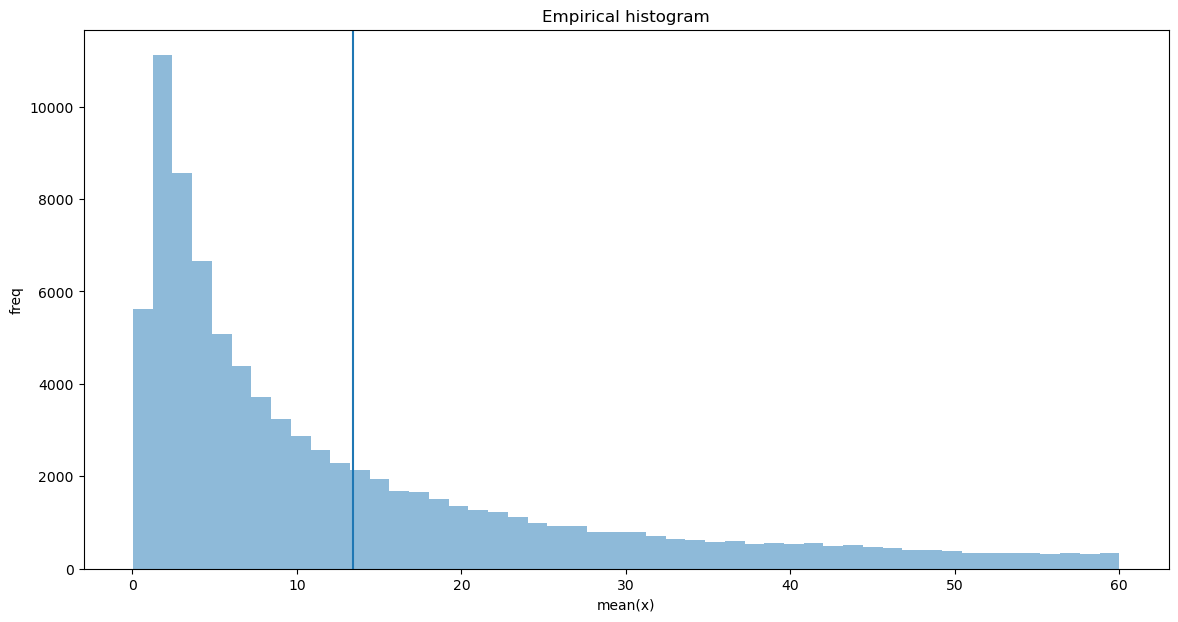

In [34]:
_, ax = plt.subplots(figsize = (14, 7))
plt.hist(airlines['res_time'], bins = 50, alpha = 0.5)
ax.axvline(airlines['res_time'].mean())
ax.set(title = 'Empirical histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

### Simulated Plot

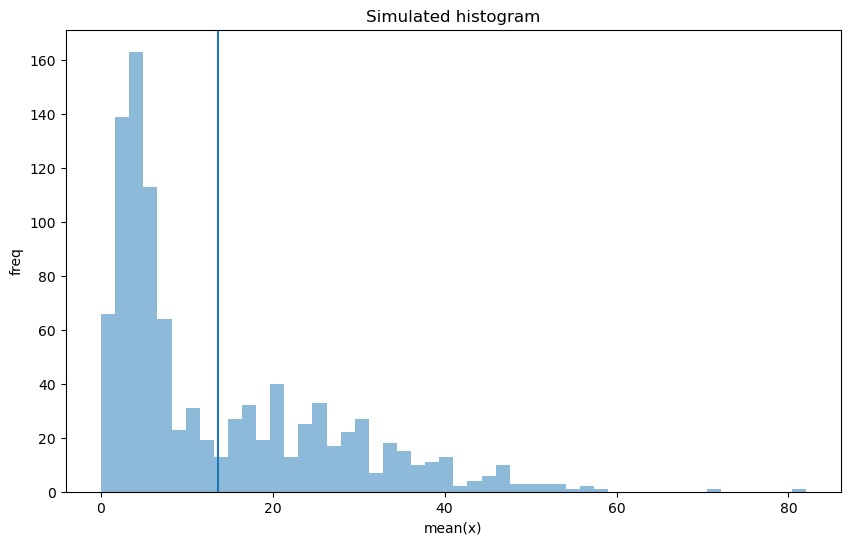

In [35]:
final_data = total[(total >= 0) & (total <= 80)]
data = np.random.choice(clean_data.flatten(), size=1000, replace=False)

# Plot the cleaned data as a histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(data.flatten(), bins=50, alpha=0.5)
ax.axvline(np.mean(final_data))
ax.set(title = 'Simulated histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')
plt.show()

### Verification with actual mean !

In [36]:
airlines['res_time'].mean()

13.436461105326302

# 2. Question 2
Each airline appears to have a different response time mean, which also differ if they were written on the weekend or on a work week day:

In [16]:
airlines.groupby(['author_id_y', 'created_at_y_is_weekend'])['res_time'].mean()

author_id_y      created_at_y_is_weekend
AirAsiaSupport   0                          23.472410
                 1                          20.694675
AlaskaAir        0                           6.624140
                 1                           5.630935
AmericanAir      0                          15.114572
                 1                          15.937899
British_Airways  0                          25.866365
                 1                          25.710606
Delta            0                          13.674155
                 1                          19.382936
JetBlue          0                           5.594833
                 1                           5.418759
SouthwestAir     0                          10.887163
                 1                          11.220752
VirginAmerica    0                           6.534827
                 1                           5.302918
VirginAtlantic   0                          17.487750
                 1                       

In [17]:
airlines.groupby('created_at_y_day_of_week')['res_time'].mean()

created_at_y_day_of_week
Friday       13.836451
Monday       13.457364
Saturday     14.508340
Sunday       14.996341
Thursday     12.550116
Tuesday      13.376829
Wednesday    11.924251
Name: res_time, dtype: float64

In [18]:
airlines.groupby('created_at_y_is_weekend')['res_time'].mean()

created_at_y_is_weekend
0    13.028558
1    14.761335
Name: res_time, dtype: float64

The mean of the response word count however seems to be pretty similar across airlines: 

In [19]:
airlines.groupby(['author_id_y', 'created_at_y_is_weekend'])['word_count'].mean()

author_id_y      created_at_y_is_weekend
AirAsiaSupport   0                          18.040323
                 1                          18.160681
AlaskaAir        0                          15.501401
                 1                          15.226138
AmericanAir      0                          18.576909
                 1                          18.634488
British_Airways  0                          20.998643
                 1                          21.187779
Delta            0                          18.235353
                 1                          18.322811
JetBlue          0                          16.463764
                 1                          17.018355
SouthwestAir     0                          20.531087
                 1                          20.946030
VirginAmerica    0                          15.188312
                 1                          15.175055
VirginAtlantic   0                          17.323657
                 1                       

The `word_count` mean and variance however are very different:

In [20]:
airlines.groupby(['author_id_y', 'created_at_y_is_weekend'])['word_count'].agg(['mean', 'var'])

mean        var
author_id_y     created_at_y_is_weekend                      
AirAsiaSupport  0                        18.040323  27.203802
                1                        18.160681  40.006330
AlaskaAir       0                        15.501401  47.063517
                1                        15.226138  46.095775
AmericanAir     0                        18.576909  28.035661
                1                        18.634488  27.118236
British_Airways 0                        20.998643  68.150745
                1                        21.187779  75.979612
Delta           0                        18.235353  67.589541
                1                        18.322811  71.221825
JetBlue         0                        16.463764  83.450360
                1                        17.018355  87.090772
SouthwestAir    0                        20.531087  49.954286
                1                        20.946030  49.019399
VirginAmerica   0                        15.188312  40.601293
                1                        15.175055  42.464903
VirginAtlantic  0                        17.323657  56.583686
                1                        18.686695  59.971900

# Hint: The Negative binomial distribution
A [Negative binomial](https://modelassist.epixanalytics.com/display/EA/Negative+Binomial) likelihood is used to model count data for which the variance is higher than the mean. 

The negative Binomial distribution has very similar characteristics to the Poisson distribution except that it has *two* parameters $\mu$ and $\alpha$, which enables it to vary variance independently of the mean. 

Recall that the Poisson distribution has one parameter, the expectation, that represents both its mean and its variance.

The Negative Binomial distribution estimates the total number of trials there will be before s successes are achieved where there is a probability p of success with each trial. The total number of trials is equal to the number of failures plus the s successes.

The negative binomial distribution describes a Poisson random variable whose rate parameter is not constant, but gamma distributed.

More specifically, the NegBinomial distribution has two applications for a binomial process:

- The total number of trials n in order to achieve s successes = NegBinomial(p,s);
- The total number of trials there might have been when we have observed s successes = NegBinomial(p,s+1)-1

The first use is when we know that we will stop at the sth success. The second is when we only know that there had been a certain number of successes.

>For example, a hospital has received a total of 17 people with a rare disease in the last month. The disease has a long incubation period. There have been no new admissions for this disease for a fair number of days. The hospital knows that people infected with this problem have a 65% chance of showing symptoms. It is also known that all people with symptoms will turn up at the hospital. How many other infected people are there out in the community? The answer is NegBinomial(65%,17+1)-(17+1). IF we knew (we don't) that the last person to be infected was symptomatic, the answer would be NegBinomial(65%,17) - 17. The total number infected would be NegBinomial(65%,17+1) -1.

The Negative Binomial distribution is frequently used in accident statistics and other Poisson processes because the Negative Binomial distribution can be derived as a Poisson random variable whose rate parameter lambda is itself random and Gamma distributed, i.e.:
```
Poisson(Gamma(0,b,a)) = NegBinomial(1/(b+1),a) - a
```

## Homework Question 2
Build a model of the response word count distribution for all airlines, knowing that the mean and variance for that distribution are very unequal. From the model, generate a posterior predictive distribution (simulated data), and compare with the empirical data. Is your model a good one?

### Wordcount For Weekdays

### For Weekdays ! (created_at_y_is_weekend==0)

In [37]:
df1 = airlines.loc[airlines['created_at_y_is_weekend'] == 0]

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


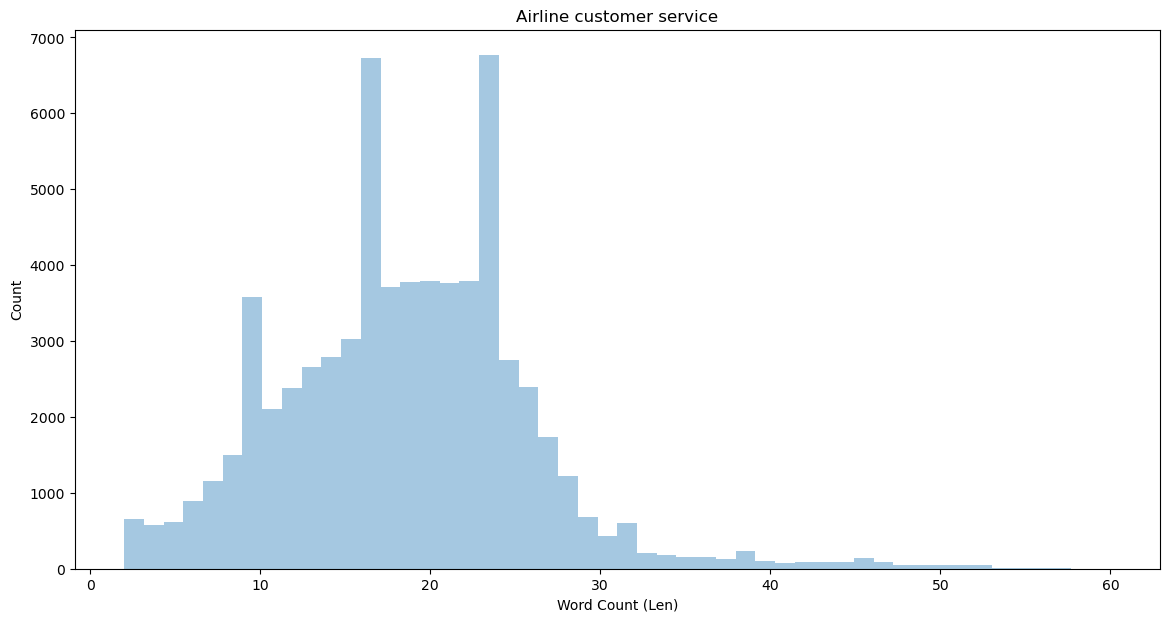

In [38]:
plt.figure(figsize = (14, 7))
sns.distplot(df1['word_count'], kde = False)
plt.title('Airline customer service')
plt.xlabel('Word Count (Len)')
plt.ylabel('Count');

In [39]:
with pm.Model() as model4:
    alpha = pm.HalfNormal('alpha', sigma=10)
    nu = pm.HalfNormal('nu', sigma=10)
    
    
    nb = pm.NegativeBinomial('nb', mu = alpha, alpha = nu, observed=df1['word_count']) 

In [40]:
with model4:
    trace1 = pm.sample(2000, tune=2000)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


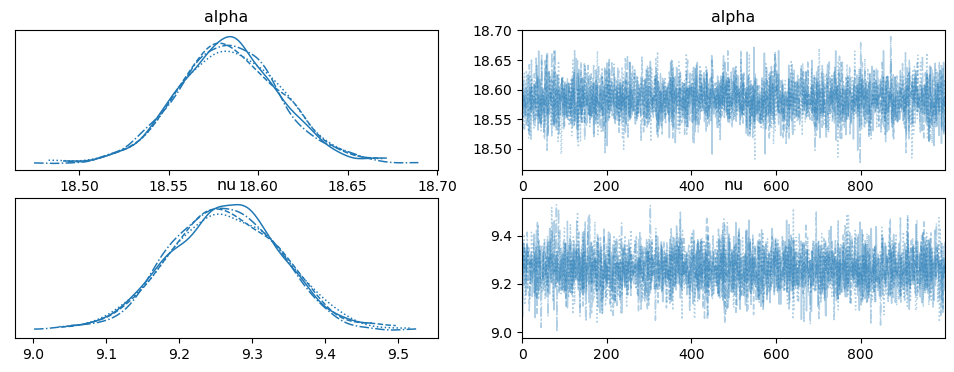

In [41]:
az.plot_trace(trace1[:1000], var_names = ['alpha','nu']);

In [42]:
ppc1 = pm.sample_posterior_predictive(trace1, samples = 1000, model = model4)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [43]:
ppc1

{'nb': array([[35, 14, 19, ..., 19, 26,  8],
        [14, 12, 10, ..., 10, 17, 21],
        [15,  7, 18, ..., 14, 16,  8],
        ...,
        [ 9, 10, 16, ..., 16, 23, 16],
        [17, 11, 10, ..., 11, 19, 17],
        [24, 29, 18, ..., 17, 11, 18]])}

### Empirical Plot

[Text(0.5, 1.0, 'Empirical histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

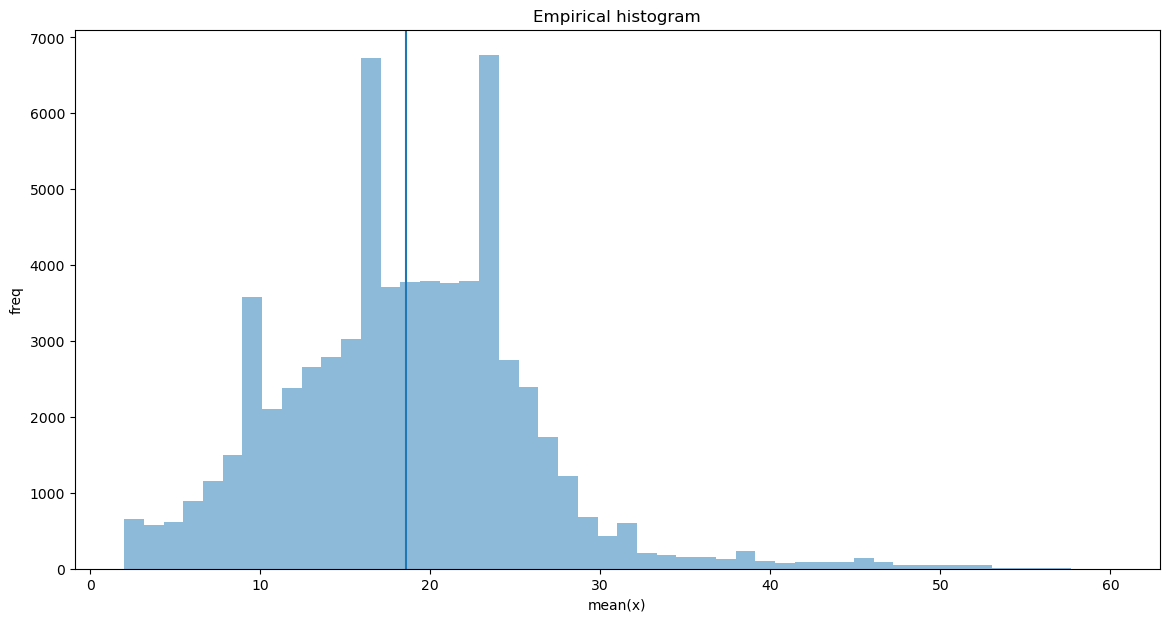

In [44]:
_, ax = plt.subplots(figsize = (14, 7))
plt.hist(df1['word_count'], bins = 50, alpha = 0.5)
ax.axvline(df1['word_count'].mean())
ax.set(title = 'Empirical histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

### Simulated Plot

[Text(0.5, 1.0, 'Simulated histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

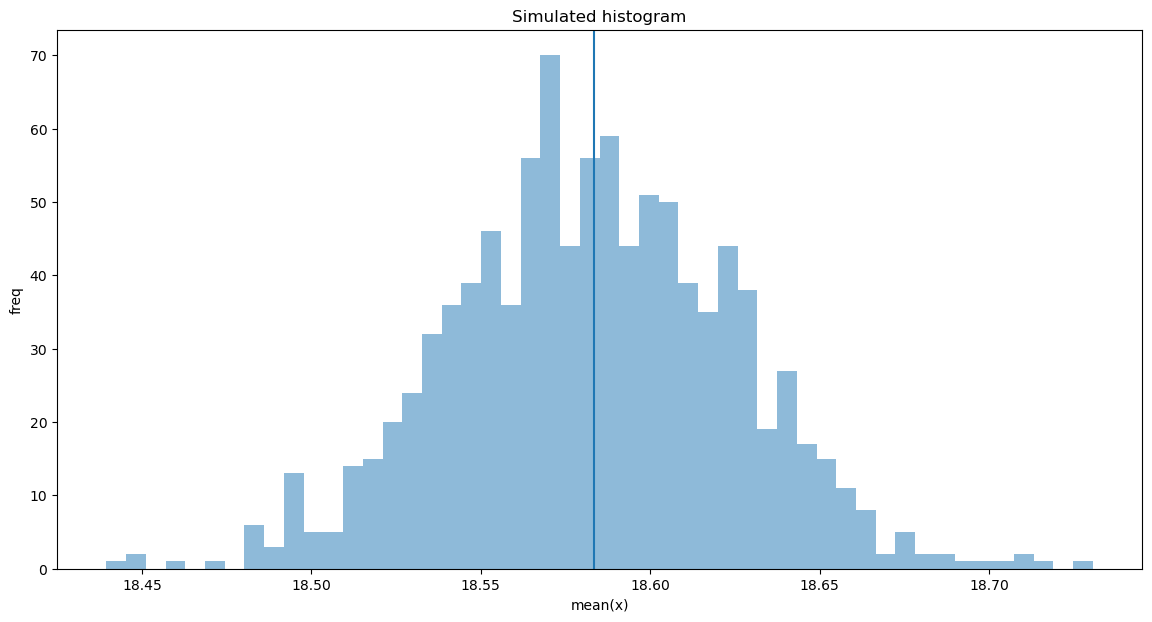

In [45]:
_, ax = plt.subplots(figsize = (14, 7))

ax.hist([n.mean() for n in ppc1['nb']], bins = 50, alpha = 0.5)
ax.axvline(df1['word_count'].mean())
ax.set(title = 'Simulated histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

### Verfiication with actual mean!!

In [46]:
df1['word_count'].mean()

18.583469523636584

### For Weekdays ! (created_at_y_is_weekend==1)¶

In [47]:
df2 = airlines.loc[airlines['created_at_y_is_weekend'] == 1]

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


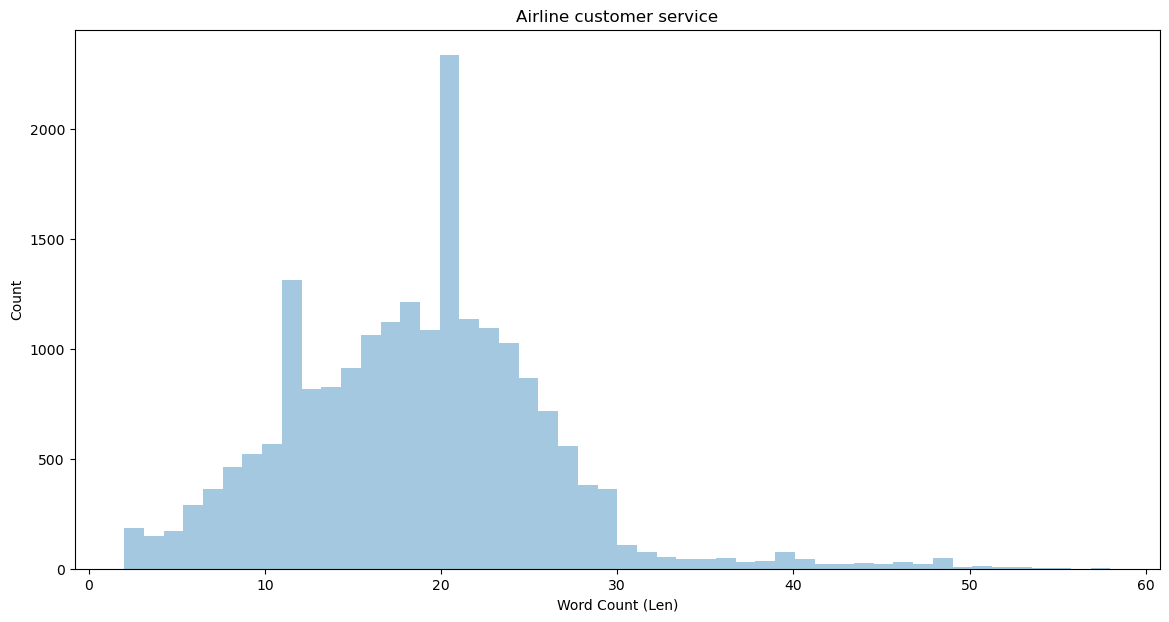

In [48]:
plt.figure(figsize = (14, 7))
sns.distplot(df2['word_count'], kde = False)
plt.title('Airline customer service')
plt.xlabel('Word Count (Len)')
plt.ylabel('Count');

In [49]:
with pm.Model() as model5:
    alpha = pm.HalfNormal('alpha', sigma=10)
    nu = pm.HalfNormal('nu', sigma=10)
    
    
    nb1 = pm.NegativeBinomial('nb', mu = alpha, alpha = nu, observed=df2['word_count']) 

In [50]:
with model5:
    trace2 = pm.sample(2000, tune=2000)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


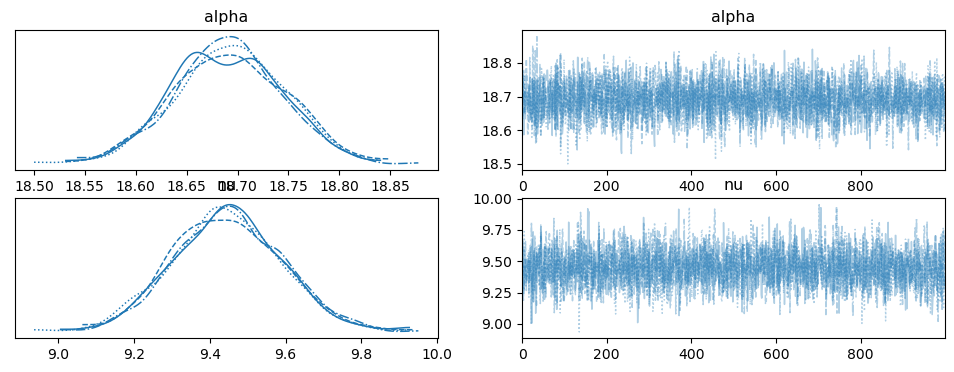

In [51]:
az.plot_trace(trace2[:1000], var_names = ['alpha','nu']);

In [52]:
ppc2 = pm.sample_posterior_predictive(trace2, samples = 1000, model = model5)

/Users/anirudhajoshi/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [53]:
ppc2

{'nb': array([[12,  7, 13, ..., 16, 14, 24],
        [18, 12, 16, ..., 10, 15, 15],
        [15, 12, 20, ...,  8,  5, 26],
        ...,
        [21, 29, 21, ..., 20, 17, 11],
        [26, 16, 19, ..., 10, 31, 21],
        [28, 25, 19, ..., 10, 29, 18]])}

[Text(0.5, 1.0, 'Empirical histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

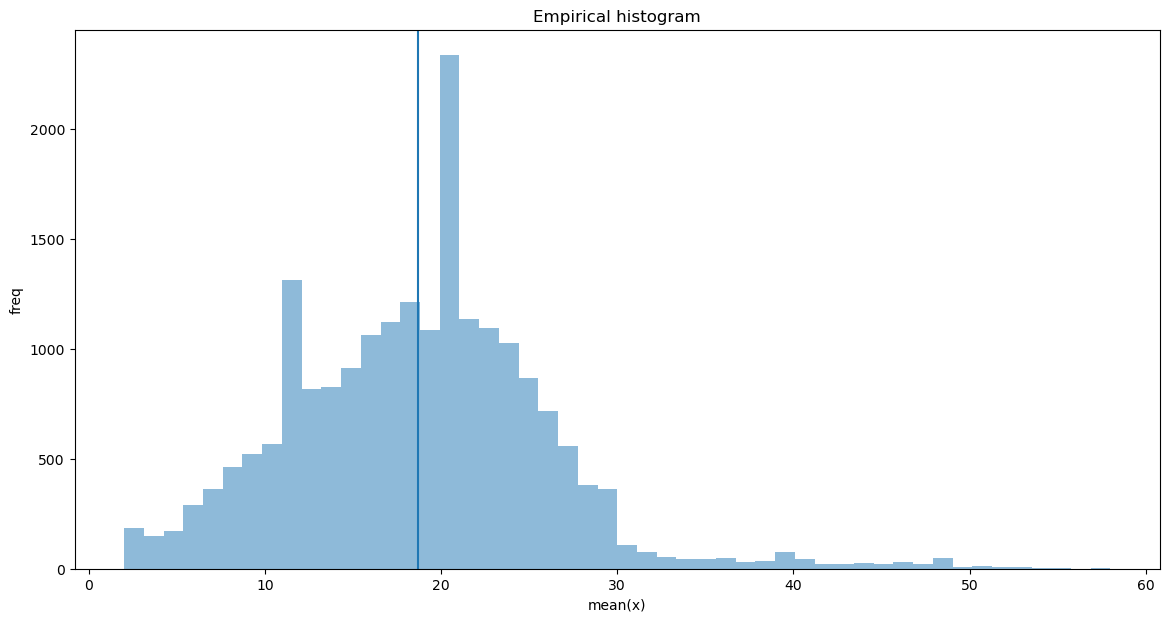

In [54]:
_, ax = plt.subplots(figsize = (14, 7))
plt.hist(df2['word_count'], bins = 50, alpha = 0.5)
ax.axvline(df2['word_count'].mean())
ax.set(title = 'Empirical histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

[Text(0.5, 1.0, 'Simulated histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

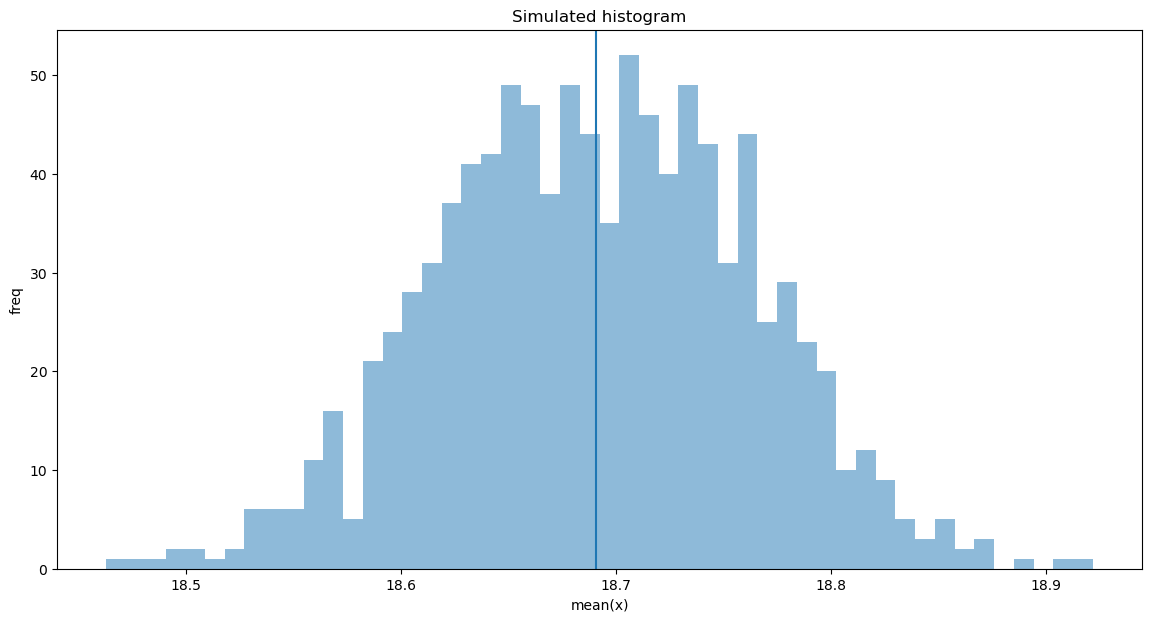

In [55]:
_, ax = plt.subplots(figsize = (14, 7))

ax.hist([n.mean() for n in ppc2['nb']], bins = 50, alpha = 0.5)
ax.axvline(df2['word_count'].mean())
ax.set(title = 'Simulated histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

### Verification with actual mean!

In [56]:
df2['word_count'].mean()

18.690602575444807